<a href="https://colab.research.google.com/github/sebasmos/vector-borne-satellite-predictor/blob/main/Deep_learning_for_Vector_Borne_Diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep learning for Vector-Borne Diseases

Complementary open-source collaboration for [MIT Critical data](https://github.com/MITCriticalData-Colombia/Dengue-Prediction-with-Satellite-Images) and [Mimi utily functions](https://github.com/MITCriticalData-Colombia/Dengue-Prediction-with-Satellite-Images)




In [ ]:
!pip install epiweeks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from torchvision.datasets.folder import pil_loader
img_folder = 'gdrive/My Drive/dataset_rbg'
csv_folder = 'gdrive/My Drive/csv/merge_cases_temperature_WeeklyPrecipitation_timeseries.csv'
df = df.append(pd.read_csv(csv_folder))

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import os
import time
import sys
sys.path.insert(0,'..')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import  mean_absolute_error
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import seaborn as sns
from scipy import signal
import pickle

from sklearn.decomposition import PCA

from epiweeks import Week, Year
from datetime import date

from random import randint, randrange
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

import skimage
import cv2
import os
import pandas as pd
import numpy as np
import pickle
import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
#torch.cuda.empty_cash()
import torch
torch.cuda.empty_cache()


In [ ]:
def get_MAE_score(y_test, y_pred):
  # y_test = y_test.detach().numpy()
  # y_pred = y_pred.detach().numpy()
  # y_test = torch.from_numpy(y_test)
  # y_pred = torch.from_numpy(y_pred)
  return round(mean_absolute_error(y_test, y_pred), 4)

def get_MAPE_score(y_true, y_pred):
  """Get Mean Absolute Percentage Error (MAPE)
  
  Calculate the MAPE score based on the prediction. 
  The lower MAPE socre is, the better the predictions are.

  """
  return round(mean_absolute_percentage_error(y_true, y_pred), 4)
def readImg(img_path, resize_ratio=None):
  img = io.imread(img_path)

  if resize_ratio:
    img_rescale = rescale(img, resize_ratio, anti_aliasing=True)

  print(os.path.basename(img_path), '(origin shape:', img.shape, '-> rescale:', str(img_rescale.shape) + ')')
  return img_rescale


# Load data from one of the source
def loadData(csv_folder, img_folder, option=None, resize_ratio=None):
  if option is None:
    # Get data by combining from csv and images
    df = loadStructuredData(csv_folder)
    info_dict = combineData(img_folder, df, resize_ratio)
    
    print(len(info_dict['LastDayWeek']), len(info_dict['Image']), len(info_dict['cases_medellin']))

  else:
    # Load data from previous pickle file
    info_dict = 1#loadDataFromPickle(option)
  return info_dict
  

def loadStructuredData(csv_path):
  df = pd.DataFrame()
  if os.path.isdir(csv_path):
    for filename in os.listdir(csv_path):
      file_path = os.path.join(csv_path, filename)
      df = df.append(pd.read_csv(file_path))
  elif os.path.isfile(csv_path):
    df = pd.read_csv(csv_path)
  else:
    print('Error: Not folder or file')
  return df
  
def getEpiWeek(origin_str):
  """Get epi week from string
  """
  date_ls = origin_str.split('-')
  return Week.fromdate(date(int(date_ls[0]), int(date_ls[1]), int(date_ls[2])))
  
def combineData(img_folder, df, resize_ratio=None):
  info_dict = {'LastDayWeek':[], 'cases_medellin':[], 'Image':[], 'epi_week':[]}
  img_list = os.listdir(img_folder)

  for index, row in df.iterrows():
    name = row['LastDayWeek']
    week_df = str(getEpiWeek(name))
    case = row['cases_medellin']
    for img_name in img_list:
      
      # If image name is image_2017-12-24.tiff -> get 2017-12-24
      # Reference Links: https://www.w3schools.com/python/ref_string_join.asp, 
      #                  https://stackoverflow.com/questions/13174468/how-do-you-join-all-items-in-a-list/13175535
      new_img_name = ''.join(i for i in img_name if i.isdigit() or i == '-')      

      week_img = str(getEpiWeek(new_img_name))
      #print(f"{week_df} = {week_img}")
      if week_df == week_img:
        #print("ENTRO")
        img_path = os.path.join(img_folder, img_name)
        img = readImg(img_path, resize_ratio)

        info_dict['Image'].append(img)
        info_dict['LastDayWeek'].append(name)
        info_dict['cases_medellin'].append(case)
        info_dict['epi_week'].append(week_df)
        break

  return info_dict

def splitTrainTestSet(ratio):
  # Split the data into training (ratio) and testing (1 - ratio)
  train_val_ratio = ratio
  train_num = int(len(info_dict['Image']) * train_val_ratio)

  # Change list to array
  origin_dimension_X = np.array(info_dict['Image'])
  labels = np.array(info_dict['cases_medellin'])

  print(''.center(60,'-'))

  origin_X_train = origin_dimension_X[:train_num,:,:,:]
  y_train = labels[:train_num]
  origin_X_test = origin_dimension_X[train_num:,:,:,:]
  y_test = labels[train_num:]

  # print('Total number of weeks:'.ljust(30), len(origin_dimension_X), 'weeks')
  # print('Training input:'.ljust(30), origin_X_train.shape)
  # print('Training output:'.ljust(30), y_train.shape)
  # print('Testing input:'.ljust(30), origin_X_test.shape)
  # print('Testing output:'.ljust(30), y_test.shape) 

  return origin_X_train, y_train, origin_X_test, y_test

# Polynomial Regression
def calc_r_2(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])

    return ssreg / sstot

def classified_with_SVR(origin_X_train, origin_X_test, y_train, y_test):
  print('[SVR]'.center(100, '-'))

  reshape_X_train = origin_X_train.reshape(origin_X_train.shape[0], -1)
  reshape_X_test = origin_X_test.reshape(origin_X_test.shape[0], -1)

  regressor = SVR(C=1.0, epsilon=0.2)
  regressor.fit(reshape_X_train, y_train)

  float_y_pred = regressor.predict(reshape_X_test)
  int_y_pred = [int(i) for i in float_y_pred]

  print('Predicted')
  print(' '.ljust(3, ' '), 'List =', int_y_pred)
  print(' '.ljust(3, ' '), 'Mean =', round(np.mean(int_y_pred), 4))
  print('')

  print('Real')
  print(' '.ljust(3, ' '), 'List =', y_test)
  print(' '.ljust(3, ' '), 'Mean =', round(np.mean(y_test), 4))
  print('')
  
  MAE = get_MAE_score(y_test, int_y_pred)
  MAPE = get_MAPE_score(y_test, int_y_pred)

  r_2 = calc_r_2(y_test, int_y_pred, 15)

  print('- MAE: ', str(MAE).rjust(8), '(cases different in average)')
  print('- MAPE:', str(MAPE).rjust(8), '(times different in average)')
  print('- r_squared:', str(r_2).rjust(8), '(times different in average)')

  return MAE, MAPE, r_2



def dimension_reduct_with_PCA(origin_X_train, origin_X_test, y_train):
  print(' PRINCIPAL COMPONENT ANALYSIS  '.center(100, '='))

  reshape_X_train = origin_X_train.reshape(origin_X_train.shape[0], -1)
  reshape_X_test = origin_X_test.reshape(origin_X_test.shape[0], -1)

  pca = PCA(n_components=0.95) 
  pca_X_train = pca.fit_transform(reshape_X_train)

  pca_X_test = pca.transform(reshape_X_test)
  print('Origin shape'.ljust(15), reshape_X_train.shape)
  print('Resize shape'.ljust(15), pca_X_train.shape)  

  return pca_X_train, pca_X_test

In [ ]:
% cd /content/drive/MyDrive/Dengue_prediction

/content/drive/MyDrive/Dengue_prediction


In [ ]:
from torchvision.datasets.folder import pil_loader

dataset_folder = "/content/drive/MyDrive/Dengue_prediction"
# Change to dataset location here or add shortcut to path 
# dataset RGB: https://drive.google.com/drive/folders/1f1qWh-Xls8fV4hrv1IhCwsAwnEqYuO-U?usp=sharing
image_name = "./Dengue Research paper/dataset_2015_2018/Sentinel_L1C_2016_2021/dataset_rbg"
img_folder = os.path.join(dataset_folder, image_name)
csv_folder = './csv/merge_cases_temperature_WeeklyPrecipitation_timeseries.csv'
info_dict = loadData(csv_folder, img_folder, resize_ratio=(0.7, 0.7, 1))

print('INFO_DICT'.center(50, '-'))
print('keys:', info_dict.keys())
print('')

print('DENGUE CASES'.center(50, '-'))
print('Max weekly dengue cases:', max(info_dict['cases_medellin']))
print('Min weekly dengue cases:', min(info_dict['cases_medellin']))
print('')

print('WEEKS'.center(50, '-'))
print('Max week:', max(info_dict['LastDayWeek']))
print('Min week:', min(info_dict['LastDayWeek']))

image_2016-01-03.tiff (origin shape: (1205, 765, 3) -> rescale: (844, 536, 3))
image_2016-01-10.tiff (origin shape: (1205, 765, 3) -> rescale: (844, 536, 3))
image_2016-01-17.tiff (origin shape: (1205, 765, 3) -> rescale: (844, 536, 3))
image_2016-01-24.tiff (origin shape: (1205, 765, 3) -> rescale: (844, 536, 3))
image_2016-02-07.tiff (origin shape: (1205, 765, 3) -> rescale: (844, 536, 3))
image_2016-02-14.tiff (origin shape: (1205, 765, 3) -> rescale: (844, 536, 3))
image_2016-03-06.tiff (origin shape: (1205, 765, 3) -> rescale: (844, 536, 3))
image_2016-03-20.tiff (origin shape: (1205, 765, 3) -> rescale: (844, 536, 3))
image_2016-04-03.tiff (origin shape: (1205, 765, 3) -> rescale: (844, 536, 3))
image_2016-04-17.tiff (origin shape: (1205, 765, 3) -> rescale: (844, 536, 3))
image_2016-04-24.tiff (origin shape: (1205, 765, 3) -> rescale: (844, 536, 3))
image_2016-05-01.tiff (origin shape: (1205, 765, 3) -> rescale: (844, 536, 3))
image_2016-05-08.tiff (origin shape: (1205, 765, 3) 

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
train_val_ratio = 0.8
train_num = int(len(info_dict['Image']) * train_val_ratio)

  # Change list to array
origin_dimension_X = np.array(info_dict['Image'])
labels = np.array(info_dict['cases_medellin'])

print(''.center(60,'-'))

origin_X_train = origin_dimension_X[:train_num,:,:,:]
y_train = labels[:train_num]
origin_X_test = origin_dimension_X[train_num:,:,:,:]
y_test = labels[train_num:]

print(f"origin_X_train: {origin_X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"origin_X_train: {origin_X_test.shape}")
print(f"y_train: {y_test.shape}")


------------------------------------------------------------
origin_X_train: (116, 844, 536, 3)
y_train: (116,)
origin_X_train: (29, 844, 536, 3)
y_train: (29,)


In [ ]:
origin_X_train_PCA, origin_X_test_PCA = dimension_reduct_with_PCA(origin_X_train, origin_X_test, y_train)
print(f"origin_X_train: {origin_X_train_PCA.shape}")
print(f"y_train: {y_train.shape}")
print(f"origin_X_train: {origin_X_test_PCA.shape}")
print(f"y_train: {y_test.shape}")



================================== PRINCIPAL COMPONENT ANALYSIS  ===================================
Origin shape    (116, 1357152)
Resize shape    (116, 50)
origin_X_train: (116, 50)
y_train: (116,)
origin_X_train: (29, 50)
y_train: (29,)


In [ ]:
from torch.utils.data import Dataset, DataLoader

class TrainDataset(Dataset):
    def __init__(self, data, y):
        self.data = data
        self.y = y
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, ind):
        x = self.data[ind]
        y = self.y[ind]
        return x, y
    
class TestDataset(TrainDataset):
    def __getitem__(self, ind):
        x = self.data[ind]
        return x
    
train_set = TrainDataset(origin_X_train_PCA, y_train)
test_set  = TrainDataset(origin_X_test_PCA, y_test)

batch_size = 1
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


# LSTM with ṔCA features


In [ ]:
input_size = origin_X_train_PCA.shape[1]
print(input_size)
hidden_size = 230
num_layers = 2
num_classes = 1
output_size = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model.double()

50


In [ ]:

class flightLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size,128)
        self.relu = nn.ReLU()
        self.fc   = nn.Linear(128, output_size)   
        
    def forward(self, x, hs, cs):
      
        out, (hs,cs) = self.lstm(x, (hs,cs)) # out.shape = (batch_size, seq_len, hidden_size)
        # output, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = out.view(-1, self.hidden_size) # out.shape = (seq_len, hidden_size)     
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)       
        return out

x = torch.randn((1, 1000, 50)) # batch - seq length - hidden size
hs = torch.zeros(2, x.size(0), hidden_size)
cs = torch.zeros(2, x.size(0), hidden_size)
model = flightLSTM(input_size, hidden_size, num_layers, num_classes)
pred = model(x, hs, cs)
print(pred.shape)


In [ ]:
model = flightLSTM(input_size, hidden_size, num_layers, output_size)
model.to(device)

flightLSTM(
  (lstm): LSTM(50, 230, num_layers=2, batch_first=True)
  (fc_1): Linear(in_features=230, out_features=128, bias=True)
  (relu): ReLU()
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
#from model import MPL_model

# https://medium.com/deep-learning-study-notes/multi-layer-perceptron-mlp-in-pytorch-21ea46d50e62
# cnn https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/


import torch
import torch.nn as nn
# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
running_mae = 0

losses = []

v_losses = []
# MAE
maes = []
mae_list = []
v_maes = []
v_mae_list = []
# MAPE
mape = []
mapes = []
mape_val = []
mapes_val = []



for epoch in range(epochs):

    for batch_num, input_data in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x, y = input_data
        x = x.to(device).float()
        y = y.to(device)
        x = x.unsqueeze(0)

        hs = torch.zeros(2, x.size(0), hidden_size).to(device)  
        cs = torch.zeros(2, x.size(0), hidden_size).to(device)

        output = model(x,hs,cs)
        

        loss = criterion(output, y.float())
        loss.backward()
        losses.append(loss.item())
        
        optimizer.step()

        # MAE
        error = torch.abs(output - y).sum().data
        maes.append(error)

        # MAPE 
        mape = torch.abs((output-y)/output).sum().data
        mapes.append(mape)

    with torch.no_grad():
        for batch_num, input_data in enumerate(test_loader):
            model.eval()
            optimizer.zero_grad()
            x, y = input_data
            x = x.to(device).float()
            y = y.to(device)
            x = x.unsqueeze(0)

            hs = torch.zeros(2, x.size(0), hidden_size).to(device)  
            cs = torch.zeros(2, x.size(0), hidden_size).to(device)

            output = model(x,hs,cs)

            v_loss = criterion(output, y.float())
            
            v_losses.append(loss.item())
            
            
            # MAE
            v_error = torch.abs(output - y).sum().data
            v_maes.append(v_error)

            # MAPE 
            
            mape_val = torch.abs((output-y)/output).sum().data
            mapes_val.append(mape_val)
        
    
    # MAE
    mae_list.append(sum(maes)/len(maes))
    v_mae_list.append(sum(v_maes)/len(v_maes))
    print('Epoch %d | Loss_training %6.2f | MAE_training %6.2f | MAPE_training %6.2f' % (epoch, sum(losses)/len(losses), sum(maes)/len(maes), 
                                                                                         sum(mapes)/len(mapes)))
    print('Epoch %d |      val_Loss %6.2f |      val_MAE %6.2f |      MAPE_val %6.2f' % (epoch, sum(v_losses)/len(v_losses), sum(v_maes)/len(v_maes),
                                                                                         sum(mapes_val)/len(mapes_val)))


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch 0 | Loss_training 50727.17 | MAE_training 140.66 | MAPE_training 2737.58
Epoch 0 |      val_Loss 405.71 |      val_MAE  10.02 |      MAPE_val   0.78
Epoch 1 | Loss_training 45357.74 | MAE_training 146.20 | MAPE_training 1370.10
Epoch 1 |      val_Loss 434.21 |      val_MAE  20.63 |      MAPE_val   0.79
Epoch 2 | Loss_training 40536.96 | MAE_training 139.14 | MAPE_training 924.77
Epoch 2 |      val_Loss 309.74 |      val_MAE  24.28 |      MAPE_val   5.14
Epoch 3 | Loss_training 36555.35 | MAE_training 132.12 | MAPE_training 694.37
Epoch 3 |      val_Loss 616.09 |      val_MAE  29.00 |      MAPE_val   4.09
Epoch 4 | Loss_training 32973.08 | MAE_training 123.80 | MAPE_training 555.83
Epoch 4 |      val_Loss 550.04 |      val_MAE  34.36 |      MAPE_val   4.13
Epoch 5 | Loss_training 29636.18 | MAE_training 114.74 | MAPE_training 463.66
Epoch 5 |      val_Loss 500.38 |      val_MAE  40.62 |      MAPE_val   4.03
Epoch 6 | Loss_training 26798.88 | MAE_training 106.70 | MAPE_training 397

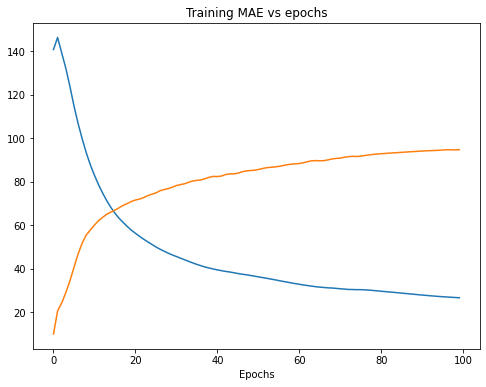

In [ ]:
epochs = range(0,100)
plt.figure(figsize=[8., 6.])
plt.plot(epochs, mae_list,  label='MAE')
plt.plot(epochs, v_mae_list, label='Val_MAE')
plt.title('Training MAE vs epochs')
plt.xlabel('Epochs')
plt.show()  

# GRU - RNN with PCA - shortened

In [ ]:
# https://towardsdatascience.com/lstms-in-pytorch-528b0440244
input_size = origin_X_train_PCA.shape[1] # The number of variables in your sequence data. 
print(input_size)
hidden_size = 100 # The number of hidden nodes in the LSTM layer.
sequence_length = 1 # its 1, but it it was an image, then this consideres the width of the image i.e. X.shape[2] as we mind the width
num_layers = 2
num_classes = 1
output_size = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

50


In [ ]:
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size,1024)
        self.relu = nn.ReLU()
        self.fc_1_1 = nn.Linear(1024,512)
        self.relu = nn.ReLU()
        self.fc   = nn.Linear(512, output_size)   
        #self.final = torch.log_softmax(output_size, dim=1)
        
    def forward(self, x, hs, cs):
      
        out, (hs,cs) = self.lstm(x, (hs,cs)) # out.shape = (batch_size, seq_len, hidden_size)
        # output, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = out.view(-1, self.hidden_size) # out.shape = (seq_len, hidden_size)     
        out = self.fc_1(out)
        out = self.relu(out)

        out = self.fc_1_1(out)
        out = self.relu(out)
        out = self.fc(out)       
        return out

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out
        
# Recurrent neural network with GRU (many-to-one)
class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.gru(x, h0)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out



In [ ]:
model = RNN_GRU(input_size, hidden_size, num_layers, output_size)
model.to(device)

RNN_GRU(
  (gru): GRU(50, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
#from model import MPL_model

# https://medium.com/deep-learning-study-notes/multi-layer-perceptron-mlp-in-pytorch-21ea46d50e62
# cnn https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/


import torch
import torch.nn as nn
# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
running_mae = 0

losses = []

v_losses = []
# MAE
maes = []
mae_list = []
v_maes = []
v_mae_list = []
# MAPE
mape = []
mapes = []
mapes_list = []
mape_val = []
mapes_val = []
mapes_val_list = []

def train(train_loader, model, criterion, optimizer):

    for batch_num, input_data in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x, y = input_data
        x = x.to(device).float()
        y = y.to(device)
        x = x.unsqueeze(0)

        hs = torch.zeros(2, x.size(0), hidden_size).to(device)  
        cs = torch.zeros(2, x.size(0), hidden_size).to(device)

        #output = model(x,hs,cs)
        output = model(x)

        loss = criterion(output, y.float())
        loss.backward()
        losses.append(loss.item())
        
        optimizer.step()

        # MAE
        error = torch.abs(output - y).sum().data
        maes.append(error)

        # MAPE 
        mape = torch.abs((output-y)/output).sum().data
        mapes.append(mape)
    
    return maes, mapes

def test(train_loader, model, criterion, optimizer):

    with torch.no_grad():
      for batch_num, input_data in enumerate(test_loader):
          model.eval()
          optimizer.zero_grad()
          x, y = input_data
          x = x.to(device).float()
          y = y.to(device)
          x = x.unsqueeze(0)

          hs = torch.zeros(2, x.size(0), hidden_size).to(device)  
          cs = torch.zeros(2, x.size(0), hidden_size).to(device)

          #output = model(x,hs,cs)
          output = model(x)
          v_loss = criterion(output, y.float())
          
          v_losses.append(loss.item())
          
          
          # MAE
          v_error = torch.abs(output - y).sum().data
          v_maes.append(v_error)

          # MAPE 
          
          mape_val = torch.abs((output-y)/output).sum().data
          mapes_val.append(mape_val)
      return v_maes, mapes_val

for epoch in range(epochs):

    print(f"Epoch {epoch+1}\n-------------------------------")

    maes, mapes = train(train_loader, model, criterion, optimizer)

    v_maes, mapes_val = test(test_loader, model, criterion, optimizer)
    
    # MAE

    mae_list.append(sum(maes)/len(maes))
    v_mae_list.append(sum(v_maes)/len(v_maes))

    mapes_list.append(sum(mapes)/len(mapes))
    mapes_val_list.append(sum(mapes_val)/len(mapes_val))

    print('Epoch %d | Loss_training %6.2f | MAE_training %6.2f | MAPE_training %6.2f' % (epoch, sum(losses)/len(losses), sum(maes)/len(maes), 
                                                                                         sum(mapes)/len(mapes)))
    print('Epoch %d | val_Loss %6.2f | val_MAE %6.2f | MAPE_val %6.2f' % (epoch, sum(v_losses)/len(v_losses), sum(v_maes)/len(v_maes),
                                                                                         sum(mapes_val)/len(mapes_val)))
    

Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch 0 | Loss_training 50036.56 | MAE_training 142.86 | MAPE_training  57.18
Epoch 0 | val_Loss 2593.94 | val_MAE  16.20 | MAPE_val   5.01
Epoch 2
-------------------------------
Epoch 1 | Loss_training 49036.79 | MAE_training 138.73 | MAPE_training  35.54
Epoch 1 | val_Loss 2593.94 | val_MAE  12.35 | MAPE_val   3.73
Epoch 3
-------------------------------
Epoch 2 | Loss_training 47856.60 | MAE_training 134.80 | MAPE_training  25.79
Epoch 2 | val_Loss 2593.94 | val_MAE  10.52 | MAPE_val   8.12
Epoch 4
-------------------------------
Epoch 3 | Loss_training 46743.76 | MAE_training 131.76 | MAPE_training  20.40
Epoch 3 | val_Loss 2593.94 | val_MAE  10.66 | MAPE_val   6.97
Epoch 5
-------------------------------
Epoch 4 | Loss_training 45730.44 | MAE_training 129.51 | MAPE_training  16.98
Epoch 4 | val_Loss 2593.94 | val_MAE  11.80 | MAPE_val   5.94
Epoch 6
-------------------------------
Epoch 5 | Loss_training 44803.75 | MAE_training 127.75 | MAPE_training  14.61
Epoch 5 | val_Loss 259

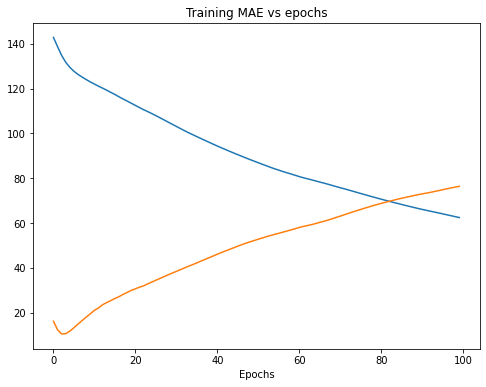

In [ ]:
epochs = range(0,100)
plt.figure(figsize=[8., 6.])
plt.plot(epochs, mae_list,  label='MAE')
plt.plot(epochs, v_mae_list, label='Val_MAE')
plt.title('Training MAE vs epochs')
plt.xlabel('Epochs')
plt.show()  

# Feature extraction off-the-shelf

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

from torchvision.datasets.utils import download_file_from_google_drive
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet50(pretrained=True)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from torch.utils.data import Dataset, DataLoader

train_transform = transforms.Compose([
      transforms.ToTensor()               
])

valid_transform = transforms.Compose([
    #transforms.Resize(224),    
    #transforms.CenterCrop(192),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))                  
])

class TrainDataset_improved(Dataset):
    def __init__(self, data, y, transform = None):
        self.data = data
        self.y = y
        self.transform = transform
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, ind):
        x = self.data[ind]
        y = self.y[ind]
        if self.transform:
          x = self.transform(x)
        return x, y
  
# This dataloader is to extract features - using toTensor() to swap channels https://stackoverflow.com/questions/64629702/pytorch-transform-totensor-changes-image 

train_set = TrainDataset_improved(origin_X_train, y_train, train_transform)
test_set  = TrainDataset_improved(origin_X_test, y_test,  valid_transform)

batch_size = 1
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False) # since is temporal data, do not shuffle on training
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [ ]:
# Verify that transformation flipped channels order for pre-trained model
cont = 0
for batch, targets in train_loader:
  print(batch.shape)
  if cont >3:
    break
  cont+=1

torch.Size([1, 3, 844, 536])
torch.Size([1, 3, 844, 536])
torch.Size([1, 3, 844, 536])
torch.Size([1, 3, 844, 536])
torch.Size([1, 3, 844, 536])


In [ ]:
train_loader.dataset.data.shape

(116, 844, 536, 3)

In [ ]:
def extract_features(loader):
    
    # put the model in eval mode
    model.eval()

    features, labels = [], []
    cont = 0
    with torch.no_grad():
        for batch, targets in loader:
            #print(cont)
            batch = batch.float()
            #print(batch.shape)
            # extract the features using the model
            batch_features = model(batch.to(device))

            features.append(batch_features.data.cpu().numpy())
            labels.append(targets.numpy())
            cont+=1

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

train_features, train_labels = extract_features(train_loader)
valid_features, valid_labels = extract_features(test_loader)

print(f'train features are {train_features.shape}')
print(f'valid features are {valid_features.shape}')

train features are (116, 1000)
valid features are (29, 1000)


In [ ]:
train_set = TrainDataset(train_features, train_labels)
test_set  = TrainDataset(valid_features, valid_labels)

batch_size = 1
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [ ]:
input_size = train_features.shape[1] # i.e. 1000 
print(input_size)
hidden_size = 1000
num_layers = 2
sequence_length = 1
num_classes = 1
output_size = 1

1000


In [ ]:
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size,1024)
        self.relu = nn.ReLU()
        self.fc_1_1 = nn.Linear(1024,512)
        self.relu = nn.ReLU()
        self.fc   = nn.Linear(512, output_size)   
        #self.final = torch.log_softmax(output_size, dim=1)
        
    def forward(self, x, hs, cs):
      
        out, (hs,cs) = self.lstm(x, (hs,cs)) # out.shape = (batch_size, seq_len, hidden_size)
        # output, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = out.view(-1, self.hidden_size) # out.shape = (seq_len, hidden_size)     
        out = self.fc_1(out)
        out = self.relu(out)

        out = self.fc_1_1(out)
        out = self.relu(out)
        out = self.fc(out)       
        return out

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out
        
# Recurrent neural network with GRU (many-to-one)
class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.gru(x, h0)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out



In [ ]:
model = flightLSTM(input_size, hidden_size, num_layers, output_size)
model.to(device)

flightLSTM(
  (lstm): LSTM(1000, 1000, num_layers=2, batch_first=True)
  (fc_1): Linear(in_features=1000, out_features=128, bias=True)
  (relu): ReLU()
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
#from model import MPL_model

# https://medium.com/deep-learning-study-notes/multi-layer-perceptron-mlp-in-pytorch-21ea46d50e62
# cnn https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/


import torch
import torch.nn as nn
# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
running_mae = 0

losses = []

v_losses = []
# MAE
maes = []
mae_list = []
v_maes = []
v_mae_list = []
# MAPE
mape = []
mapes = []
mapes_list = []
mape_val = []
mapes_val = []
mapes_val_list = []

def train(train_loader, model, criterion, optimizer):

    for batch_num, input_data in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x, y = input_data
        x = x.to(device).float()
        y = y.to(device)
        x = x.unsqueeze(0)

        hs = torch.zeros(2, x.size(0), hidden_size).to(device)  
        cs = torch.zeros(2, x.size(0), hidden_size).to(device)

        output = model(x,hs,cs)
        #output = model(x)

        loss = criterion(output, y.float())
        loss.backward()
        losses.append(loss.item())
        
        optimizer.step()

        # MAE
        error = torch.abs(output - y).sum().data
        maes.append(error)

        # MAPE 
        mape = torch.abs((output-y)/output).sum().data
        mapes.append(mape)
    
    return maes, mapes

def test(train_loader, model, criterion, optimizer):

    with torch.no_grad():
      for batch_num, input_data in enumerate(test_loader):
          model.eval()
          optimizer.zero_grad()
          x, y = input_data
          x = x.to(device).float()
          y = y.to(device)
          x = x.unsqueeze(0)

          hs = torch.zeros(2, x.size(0), hidden_size).to(device)  
          cs = torch.zeros(2, x.size(0), hidden_size).to(device)

          output = model(x,hs,cs)
          #output = model(x)
          v_loss = criterion(output, y.float())
          
          v_losses.append(v_loss.item())
          
          
          # MAE
          v_error = torch.abs(output - y).sum().data
          v_maes.append(v_error)

          # MAPE 
          
          mape_val = torch.abs((output-y)/output).sum().data
          mapes_val.append(mape_val)
      return v_maes, mapes_val

for epoch in range(epochs):

    print(f"Epoch {epoch+1}\n-------------------------------")

    maes, mapes = train(train_loader, model, criterion, optimizer)

    v_maes, mapes_val = test(test_loader, model, criterion, optimizer)
    
    # MAE

    mae_list.append(sum(maes)/len(maes))
    v_mae_list.append(sum(v_maes)/len(v_maes))

    mapes_list.append(sum(mapes)/len(mapes))
    mapes_val_list.append(sum(mapes_val)/len(mapes_val))

    print('Epoch %d | Loss_training %6.2f | MAE_training %6.2f | MAPE_training %6.2f' % (epoch, sum(losses)/len(losses), sum(maes)/len(maes), 
                                                                                         sum(mapes)/len(mapes)))
    print('Epoch %d | val_Loss %6.2f | val_MAE %6.2f | MAPE_val %6.2f' % (epoch, sum(v_losses)/len(v_losses), sum(v_maes)/len(v_maes),
                                                                                         sum(mapes_val)/len(mapes_val)))
    

Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch 0 | Loss_training 32897.84 | MAE_training 140.35 | MAPE_training   1.19
Epoch 0 | val_Loss  37.15 | val_MAE   4.43 | MAPE_val   0.21
Epoch 2
-------------------------------
Epoch 1 | Loss_training 35991.15 | MAE_training 134.39 | MAPE_training   1.88
Epoch 1 | val_Loss  40.45 | val_MAE   4.71 | MAPE_val   0.23
Epoch 3
-------------------------------
Epoch 2 | Loss_training 37168.69 | MAE_training 137.36 | MAPE_training   7.33
Epoch 2 | val_Loss  91.17 | val_MAE   7.25 | MAPE_val   0.27
Epoch 4
-------------------------------
Epoch 3 | Loss_training 37395.91 | MAE_training 138.16 | MAPE_training   6.05
Epoch 3 | val_Loss 226.16 | val_MAE  11.13 | MAPE_val   0.33
Epoch 5
-------------------------------
Epoch 4 | Loss_training 37059.73 | MAE_training 139.60 | MAPE_training   5.17
Epoch 4 | val_Loss 817.45 | val_MAE  19.91 | MAPE_val   0.40
Epoch 6
-------------------------------
Epoch 5 | Loss_training 36352.37 | MAE_training 140.54 | MAPE_training   4.52
Epoch 5 | val_Loss 1411.01 

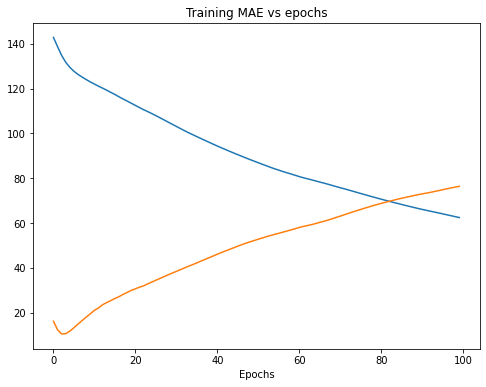

In [ ]:
epochs = range(0,100)
plt.figure(figsize=[8., 6.])
plt.plot(epochs, mae_list,  label='MAE')
plt.plot(epochs, v_mae_list, label='Val_MAE')
plt.title('Training MAE vs epochs')
plt.xlabel('Epochs')
plt.show()  